This notebook contains my replication of [this](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/) blog post by [Jake VanderPlan](http://vanderplas.com/) on using data from bicycle traffic across Seattle's Fremont Bridge to learn about commuting patterns.

In [1]:
# %load_ext nb_black

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from vega_datasets import data as vega_data

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import altair as alt; alt.renderers.enable("notebook")

from pandas.tseries.holiday import USFederalHolidayCalendar

from seattlecycling.data import get_fremont_data
from seattlecycling.toolbox import csnap

In [3]:
# Load data

start = "1 Oct 2012"
end = "30 Jun 2015"

data = get_fremont_data()
data = data.loc[start:end]
data.head(3)

,total,west,east
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0


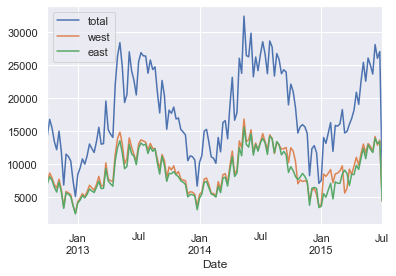

In [4]:
# A first look at the data

data.resample("w").sum().plot()

Same graph as above using Altair

In [5]:
# Create a melted dataset

melted = (
    data
    .resample('w').sum()
    .reset_index()
    .rename(columns={'Date':'date'})
    .melt(id_vars='date',
          var_name=['side'],
          value_name='crossings',
          value_vars=['total', 'east', 'west'])
)
melted.head()

,date,side,crossings
0,2012-10-07,total,14292.0
1,2012-10-14,total,16795.0
2,2012-10-21,total,15509.0
3,2012-10-28,total,13437.0
4,2012-11-04,total,12194.0


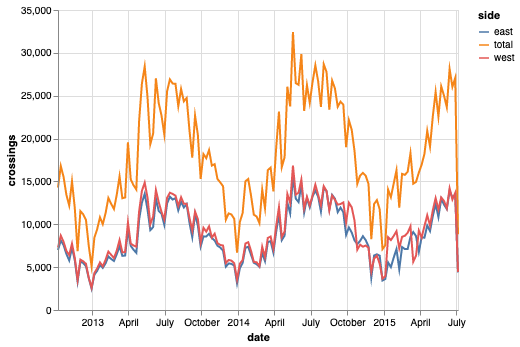

In [6]:
# Produce same graph as above

alt.Chart(melted).mark_line().encode(
    x='date',
    y='crossings',
    color='side'
)

# Visualising the data

In [7]:
# Create a datframe with days as dates and index and hours as columns
pivoted = data.pivot_table(
    ["west", "east", "total"],
    index=data.index.date,
    columns=data.index.hour,
    fill_value=0,
)
pivoted.head()

east                                     ... west                 \
Date         0  1  2  3  4   5   6    7    8    9   ...   14   15   16   17   
2012-10-03    9  6  1  3  1  10  50   95  146  104  ...   77   72  133  192   
2012-10-04   11  0  6  3  1  11  51   89  134   94  ...   63   73  114  154   
2012-10-05    7  4  3  2  2   7  37  101  119   81  ...   63   80  120  144   
2012-10-06    7  5  2  2  1   2  15   16   47   55  ...   89  115  107  107   
2012-10-07    5  5  1  2  2   3   8   12   26   36  ...  126  122  132  118   

                                     
Date         18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 72 columns]

In [8]:
# Put raw values in a matrix

X = pivoted.values
X.shape

(1001, 72)

In [9]:
# Use PCA to reduce dimensionality (keep 90 percent of the variance)

Xpca = PCA(0.9).fit_transform(X)
Xpca.shape

(1001, 2)

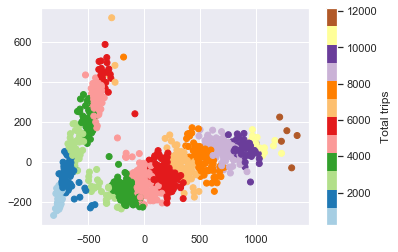

In [10]:
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips, cmap="Paired")
plt.colorbar(label="Total trips")

What can we learn from this graph? We can see that the days fall into two quite distinct cluster, one with a higher number of trips and one with a lower number of trips, that the number of trips increases along the length of each projected cluster (i.e. as we move away from the origin), and that close to the origin, the groups are less distinguishable. Overall, we can see that there are, in effect, two types of days for Seattle cyclists. This is indeed pretty cool.

# Unsupervised clustering

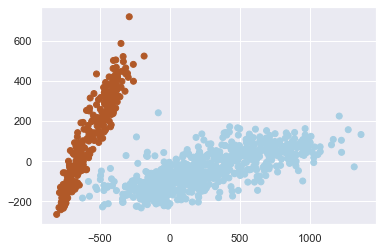

In [11]:
# Use a Gaussian mixture model to separate days into two clusters

gmm = GMM(2, covariance_type="full", random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label, cmap="Paired")

In [12]:
# Add cluster labels to original data

pivoted["cluster"] = cluster_label
data = data.join(pivoted["cluster"], on=data.index.date)
data.head()

,total,west,east,cluster
Date,,,,
2012-10-03 00:00:00,13.0,4.0,9.0,0
2012-10-03 01:00:00,10.0,4.0,6.0,0
2012-10-03 02:00:00,2.0,1.0,1.0,0
2012-10-03 03:00:00,5.0,2.0,3.0,0
2012-10-03 04:00:00,7.0,6.0,1.0,0


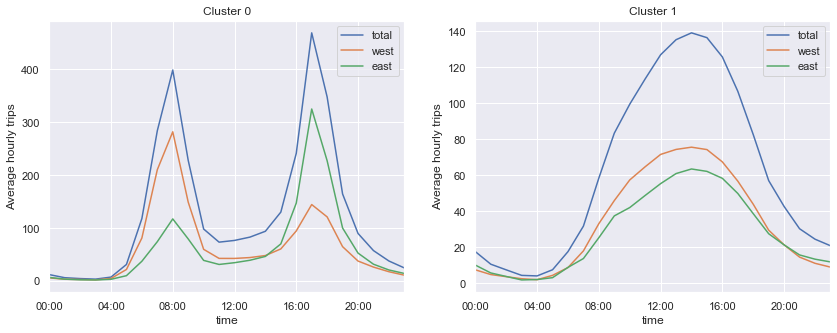

In [13]:
# Plot

hourly = data.groupby(["cluster", data.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    hourly.loc[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title("Cluster {0}".format(i))
    ax[i].set_ylabel("Average hourly trips")

First plot shows a sharp bimodal pattern, indicative of a communing pattern (with the majority of people riding west in the morning and east in the evening), while the second plot shows a wide unimodel pattern, indicative of weekend days and holidays. 

# Uncovering work habits

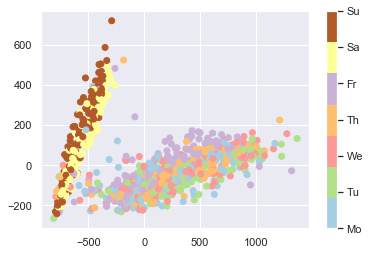

In [14]:
# Check whether two clusters correspond to weekend and weekdays

dayofweek = pd.to_datetime(pivoted.index).dayofweek

plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek, cmap=plt.cm.get_cmap("Paired", 7))

cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"])

Let's look more closely at weekdays that follow a weekend pattern, of which there are a few.

In [15]:
results = pd.DataFrame(
    {
        "cluster": pivoted["cluster"],
        "is_weekend": (dayofweek > 4),
        "weekday": pivoted.index.map(lambda x: x.strftime("%a")),
    }
)
results.head()

,cluster,is_weekend,weekday
2012-10-03,0,False,Wed
2012-10-04,0,False,Thu
2012-10-05,0,False,Fri
2012-10-06,1,True,Sat
2012-10-07,1,True,Sun


Count number of weekend days with a workday pattern

In [16]:
weekend_workdays = results.query("cluster == 0 and is_weekend")
len(weekend_workdays)

0

Count number of week days that fall into the weekend / holiday pattern

In [17]:
weekday_holidays = results.query("cluster == 1 and not is_weekend")
len(weekday_holidays)

23

There were zero weekend days where people in Seattle decided to work, but 23 weekdays that appear to be public holidasy. Let's have a look.

In [18]:
# Download list of public holidays

cal = USFederalHolidayCalendar()
holidays = cal.holidays("2012", "2016", return_name=True)
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Martin Luther King Jr. Day
2012-02-20                Presidents Day
2012-05-28                  Memorial Day
2012-07-04                      July 4th
dtype: object

In [19]:
# Add the days before and after holidays to the list

holidays_all = pd.concat(
    [
        holidays,
        "Day before " + holidays.shift(-1, "D"),
        "Day after " + holidays.shift(1, "D"),
    ]
)
holidays_all.sort_index(inplace=True)
holidays_all.head()

2012-01-01                 Day before New Years Day
2012-01-02                            New Years Day
2012-01-03                  Day after New Years Day
2012-01-15    Day before Martin Luther King Jr. Day
2012-01-16               Martin Luther King Jr. Day
dtype: object

In [20]:
# A list of holidays on which people in Seattle skip work

holidays_all.name = "name"
joined = weekday_holidays.join(holidays_all)
set(joined["name"])

{'Christmas',
 'Day after Christmas',
 'Day after Thanksgiving',
 'Day before Christmas',
 'July 4th',
 'Labor Day',
 'Memorial Day',
 'New Years Day',
 'Thanksgiving'}

In [21]:
# A list of holidays on which people in Seattle do go to work

set(holidays) - set(joined["name"])

{'Columbus Day',
 'Martin Luther King Jr. Day',
 'Presidents Day',
 'Veterans Day'}

# What's up with Fridays?

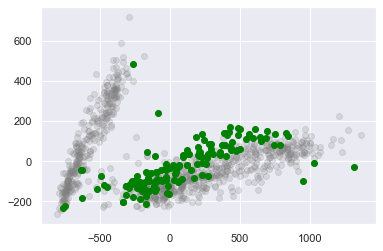

In [22]:
# Plot Fridays separately

fridays = dayofweek == 4
plt.scatter(Xpca[:, 0], Xpca[:, 1], c="gray", alpha=0.2)
plt.scatter(Xpca[fridays, 0], Xpca[fridays, 1], c="green")

What's going on with the three strange outliers in the right bottom corner?

In [23]:
# Get dates for the three outliers

weird_fridays = pivoted.index[fridays & (Xpca[:, 0] > 900)]
weird_fridays

Index([2013-05-17, 2014-05-16, 2015-05-15], dtype='object')

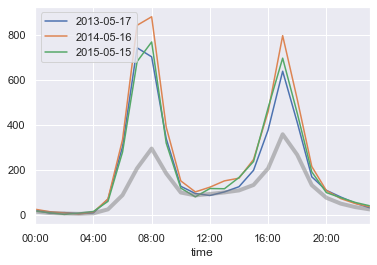

In [24]:
# Plot pattern for three outliers relative to average Friday

all_days = data.pivot_table("total", index=data.index.time, columns=data.index.date)

all_days.loc[:, weird_fridays].plot()
all_days.mean(1).plot(color="grey", lw=4, alpha=0.5, xticks=hourly_ticks)

We've found Seattle's [bike to work day](https://www.cascade.org/bikeeverywhereday).